
--- Training LightGBM ---

LightGBM Evaluation Metrics:
  MAE: 1.6979
  MSE: 7.4624
  RMSE: 2.7317
  R²: 0.8896

Top 5 Feature Importances for LightGBM:
             feature  importance
3      BIrmsAvg_Amps         561
2      AIrmsAvg_Amps         497
4      CIrmsAvg_Amps         450
0     AVrmsAvg_Volts         339
6  BVTHDRssAvg_Volts         299


C:\Users\hp\AppData\Local\Temp\ipykernel_5052\1750644285.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importances_df.head(10), palette='viridis')


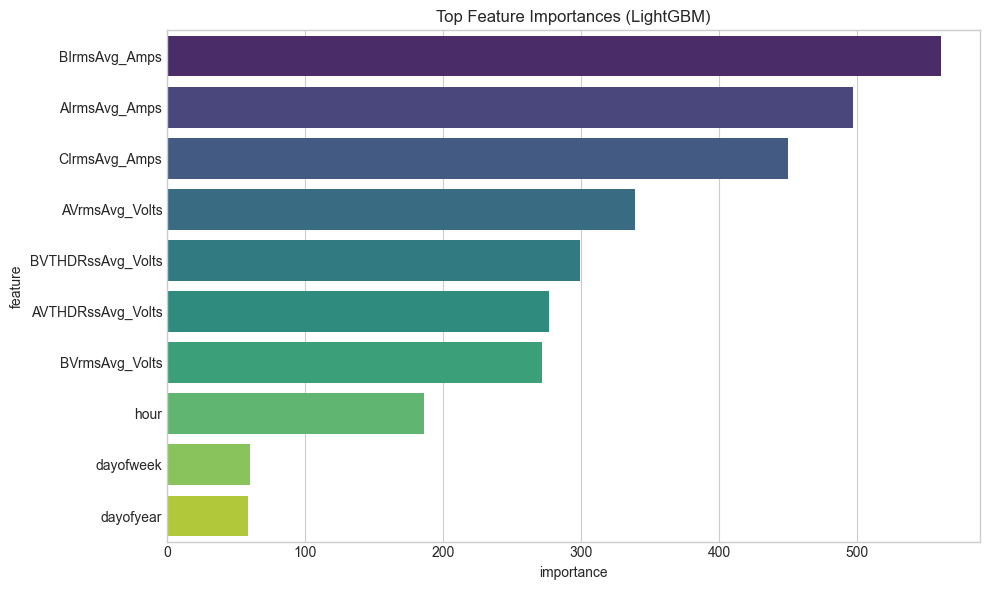


--- Training RandomForest ---

RandomForest Evaluation Metrics:
  MAE: 1.6529
  MSE: 6.8354
  RMSE: 2.6145
  R²: 0.8989

Top 5 Feature Importances for RandomForest:
             feature  importance
2      AIrmsAvg_Amps    0.902048
3      BIrmsAvg_Amps    0.045910
4      CIrmsAvg_Amps    0.011410
5  AVTHDRssAvg_Volts    0.008936
7               hour    0.007366


C:\Users\hp\AppData\Local\Temp\ipykernel_5052\1750644285.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importances_df.head(10), palette='viridis')


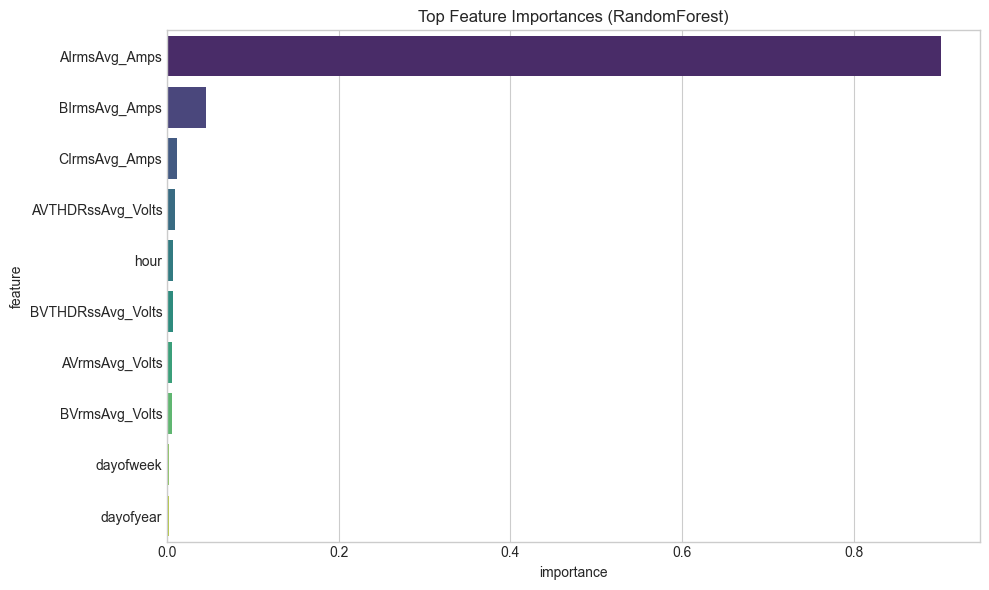

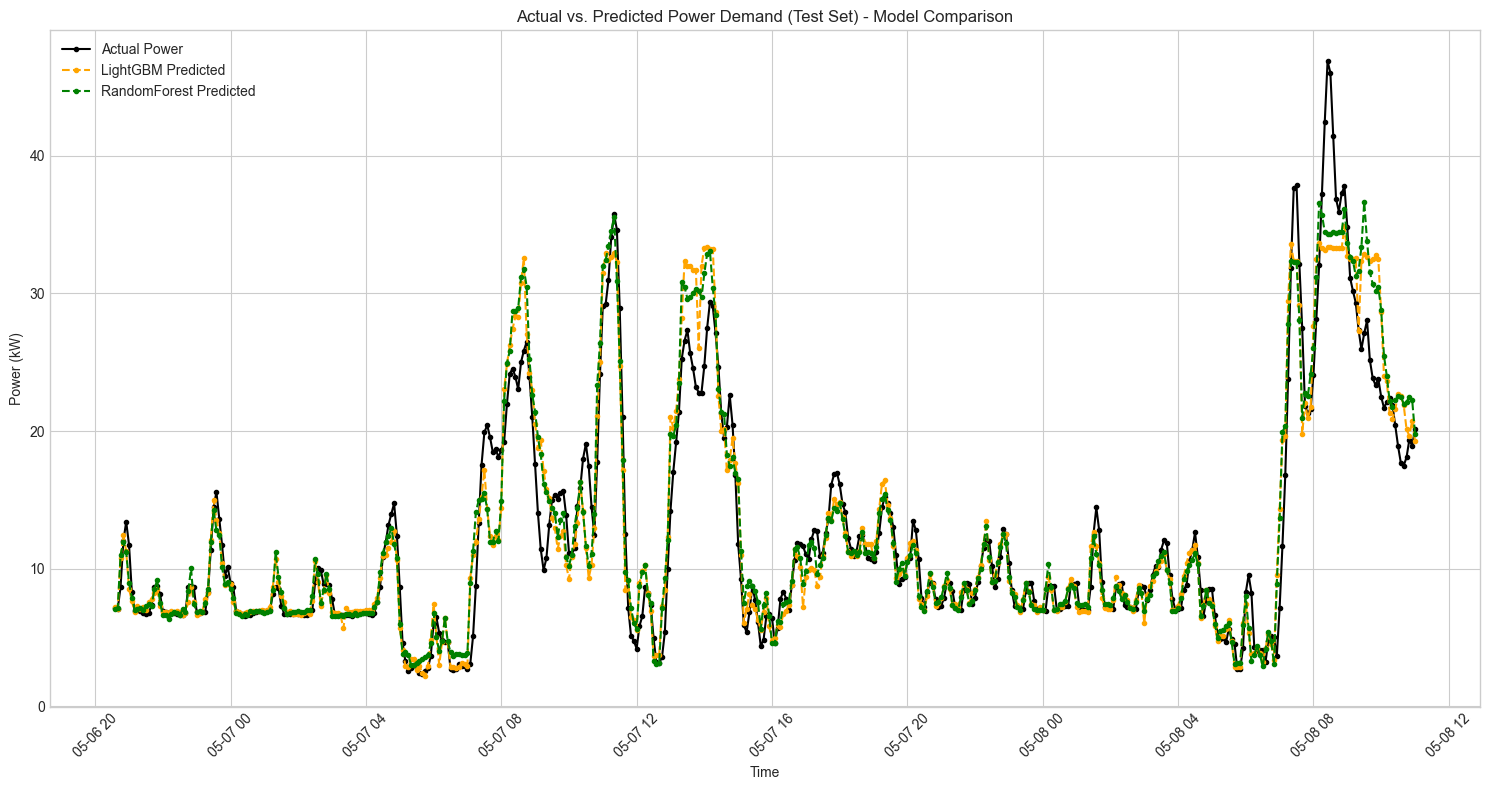


--- Model Comparison Summary ---
                   MAE       MSE      RMSE        R2
LightGBM      1.697915  7.462421  2.731743  0.889622
RandomForest  1.652898  6.835407  2.614461  0.898896

--- Comparison pipeline execution complete ---


In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split # Though we'll do a chronological split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

def run_comparison_pipeline():
    # --- Load and Prepare Data (Same as before) ---
    file_path = r"C:\Users\hp\Desktop\REG108S\Project\MeasuredData_Filled.csv" # Ensure this file is accessible
    
    df = pd.read_csv(file_path)
    

    df['X-Data'] = pd.to_datetime(df['X-Data'])
    df.set_index('X-Data', inplace=True)

    original_columns = df.columns.tolist()
    new_columns = [col.replace('[', '_').replace(']', '').replace('(', '_').replace(')', '').replace('/', '_') for col in original_columns]
    df.columns = new_columns

    columns_to_drop = ['CVrmsAvg_Volts', 'CVTHDRssAvg_Volts']
    existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
    if existing_columns_to_drop:
        df.drop(columns=existing_columns_to_drop, inplace=True)
    # No print statement here for brevity, assume previous step confirmed drops

    anomalous_rows_mask = (df['AVrmsAvg_Volts'] < 100)
    df_cleaned = df[~anomalous_rows_mask].copy()

    if df_cleaned.empty:
        print("Error: DataFrame is empty after removing anomalous rows. Cannot proceed.")
        return

    df_cleaned['hour'] = df_cleaned.index.hour
    df_cleaned['dayofweek'] = df_cleaned.index.dayofweek
    df_cleaned['dayofyear'] = df_cleaned.index.dayofyear
    df_cleaned['month'] = df_cleaned.index.month
    df_cleaned['quarter'] = df_cleaned.index.quarter
    df_cleaned['weekofyear'] = df_cleaned.index.isocalendar().week.astype(int)
    
    target_variable = 'TOTDemand_kWh_hValue_kWh_h'
    if target_variable not in df_cleaned.columns:
        print(f"Error: Target variable '{target_variable}' not found.")
        return

    X = df_cleaned.drop(columns=[target_variable])
    y = -1 * df_cleaned[target_variable]

    test_size = 0.2
    if len(X) < 10:
        print("Warning: Not enough data for a robust train/test split. Results may not be reliable.")
        X_train, X_test = X, X
        y_train, y_test = y, y
    else:
        split_index = int(len(X) * (1 - test_size))
        X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
        y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

    if X_train.empty or X_test.empty:
        print("Error: Training or testing set is empty after split.")
        return

    # --- Model Training and Evaluation ---
    models = {
        "LightGBM": lgb.LGBMRegressor(random_state=42, verbosity=-1),
        "RandomForest": RandomForestRegressor(random_state=42, n_estimators=100) # n_estimators is a common default
    }
    
    results_summary = {}
    all_test_predictions = {}

    for model_name, model in models.items():
        print(f"\n--- Training {model_name} ---")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        all_test_predictions[model_name] = y_pred.copy()

        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = -1.0
        if len(y_test) >= 2:
            r2 = r2_score(y_test, y_pred)
            
        results_summary[model_name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}
        
        print(f"\n{model_name} Evaluation Metrics:")
        print(f"  MAE: {mae:.4f}")
        print(f"  MSE: {mse:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  R²: {r2:.4f}")

        if hasattr(model, 'feature_importances_'):
            feature_importances_df = pd.DataFrame({
                'feature': X_train.columns, 
                'importance': model.feature_importances_
            })
            feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)
            print(f"\nTop 5 Feature Importances for {model_name}:")
            print(feature_importances_df.head(5))
            
            # Plot Feature Importance for this model
            plt.figure(figsize=(10, 6))
            sns.barplot(x='importance', y='feature', data=feature_importances_df.head(10), palette='viridis')
            plt.title(f'Top Feature Importances ({model_name})')
            plt.tight_layout()
            plt.show()

    # --- Visualization of Predictions (comparing models) ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(15, 8))
    plt.plot(y_test.index, y_test, label='Actual Power', marker='.', linestyle='-', color='black')
    
    colors = {'LightGBM': 'orange', 'RandomForest': 'green'}
    for model_name, y_pred_values in all_test_predictions.items():
        plt.plot(y_test.index, y_pred_values, label=f'{model_name} Predicted', marker='.', linestyle='--', color=colors.get(model_name, 'blue'))
        
    plt.title('Actual vs. Predicted Power Demand (Test Set) - Model Comparison')
    plt.xlabel('Time')
    plt.ylabel('Power (kW)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Print summary table
    results_df = pd.DataFrame(results_summary).T
    print("\n--- Model Comparison Summary ---")
    print(results_df)
    
    return df_cleaned, models, all_test_predictions


if __name__ == '__main__':
    df_processed, trained_models, test_predictions = run_comparison_pipeline()
    
    if df_processed is not None:
        print("\n--- Comparison pipeline execution complete ---")